In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore

start = 0
goal = 10
actual = 0
moment_of_inertia = 2
dt = 0.1

class NewPID:
    def __init__(self, intertia, dt=0.1, max_torque = 5, momentum=0.2, overshoot_threshold=0.5):
        self.intertia = intertia
        self.kp = 0.01
        self.ki = 0.01
        self.kd = 0.01
        self.integral = 0.0
        self.prev_error = 0.0
        self.actual_velocity = 0.0
        self.dt = dt
        self.max_torque = max_torque
        self.momentum = momentum
        self.overshoot_threshold = overshoot_threshold
    
    def newton_second_law(self, torque):
        """ Computes acceleration based on Newton's second law of motion. """
        output = min(self.max_torque, torque) / self.intertia
        return output

    def simulate_motion(self, rqst_velocity, params : dict = None):
        """ Simulates motion based on the torque input and updates the rqst_velocity. """
        if params is None:
            params = {"kp": self.kp, "ki": self.ki, "kd": self.kd}

        acceleration = self.newton_second_law(self.compute_value_based_on_pid(rqst_velocity, params = params))
        self.actual_velocity += acceleration * self.dt
        return self.actual_velocity
    
    def moving_average(self, data, window_size=5):
        padded_data = np.pad(data, (window_size//2, window_size-1-window_size//2), mode='edge')
        return np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')

    def compute_value_based_on_pid(self, rqst_velocity, update_values=True, params : dict = None):
        """ 
        Computes the PID value based on the error and the PID constants.
        For our purposes, this outputs the torque value 
        """
        if params is None:
            params = {"kp": self.kp, "ki": self.ki, "kd": self.kd}
        
        error = rqst_velocity - self.actual_velocity
        derivative = (error - self.prev_error) / self.dt if self.dt > 0 else 0

        if update_values:
            self.integral += error
            self.prev_error = error
        output = params.get("kp") * error + params.get("ki") * self.integral + params.get("kd") * derivative

        if output > self.max_torque:
            output = self.max_torque
            
        return output
    
    def compute_error_grad(self, goal, max_time=100, params : dict = None):

        """"
        Params is the dictionary of PID values to be used for the simulation.
        """

        self.reset()

        total_error = 0
        max_velocity = 0
        data = []

        time = np.arange(0, max_time, self.dt)
        for _ in time:
            velocity = self.simulate_motion(goal, params)
            total_error += abs(goal - velocity)
            max_velocity = max(max_velocity, velocity)  # Track the max velocity
            data.append(velocity)

        # Penailty is relative to how far the max velocity is from the goal
        penality = abs(max_velocity - goal) * 0.3

        # Check for overshoot and increase error if necessary
        if max_velocity > goal + self.overshoot_threshold:
            total_error += penality
            # print(f"Overshoot detected! Penalty applied: {penality:.2f}. The max velocity was {max_velocity:.2f} when I should not have surpassed {goal:.2f} by more than {self.overshoot_threshold:.2f}.")

        total_error = total_error / len(time)  # Normalize the error

        print(f"{Fore.CYAN}Simulating complete for params: {params} with error: {total_error:.2f} and max velocity: {max_velocity:.2f}{Fore.RESET}")

        return total_error, (max_velocity - goal), data
    
    def auto_tune_gradient_descent(self, goal, max_iter=500, tolerance=1e-3, learning_rate = 10, auto_accept=True, max_time = 100):
        best_kp, best_ki, best_kd, best_overshoot = self.kp, self.ki, self.kd, float('inf')
        best_data = []
        params = {"kp": 0, "ki": 0, "kd": 0}
        velocities = {"kp": 0, "ki": 0, "kd": 0}  # Velocity for momentum

        best_error, _, _ = self.compute_error_grad(goal, max_time, params)

        for _ in range(max_iter):
            base_error, _, _ = self.compute_error_grad(goal, max_time, params)
            improved = False

            gradients = {}

            for param in params.keys():
                print(f"Trying values for {param} : {params[param]}")
                original_value = params[param]
                params[param] += learning_rate
                new_error, _, _ = self.compute_error_grad(goal, max_time, params)
                grad = (new_error - base_error) / learning_rate
                velocities[param] = self.momentum * velocities[param] - learning_rate * grad
                params[param] = max(0, original_value + velocities[param])  # Ensure non-negative values
                gradients[param] = grad

            current_error, overshoot, output_data = self.compute_error_grad(goal, max_time, params)

            if current_error < best_error - tolerance:
                best_kp, best_ki, best_kd, best_overshoot = params["kp"], params["ki"], params["kd"], overshoot
                best_error = current_error
                best_data = output_data
                improved = True
                print(f"Updated PID: Kp={best_kp}, Ki={best_ki}, Kd={best_kd}, Error={best_error} Overshoot={overshoot}")

            if not improved:
                learning_rate *= 0.98  # Reduce learning rate if no improvement

        if auto_accept:
            self.kp, self.ki, self.kd = best_kp, best_ki, best_kd

        # if (len(best_data) == 0):
        #     print(f"Auto-tuning failed: No improvements made. Best PID: Kp={best_kp}, Ki={best_ki}, Kd={best_kd} Error={best_error}")
        #     raise Exception("Auto-tuning failed.")

        print(f"Final Tuned PID, Gradient Method: Kp={best_kp}, Ki={best_ki}, Kd={best_kd}, Error={best_error}, Overshoot={best_overshoot}")

        return best_data
    
    def auto_tune_range(self, goal, max_time=10, auto_accept=True):
        """Auto-tunes PID by testing a range of P, I, and D values and selecting the best based on total error and overshoot."""
        best_kp, best_ki, best_kd, best_overshoot, best_data = self.kp, self.ki, self.kd, float('inf'), []
        min_error = float('inf')
        max_overshoot = 0.5
        
        kp_range = np.linspace(0.01, 200, 30)  # Adjust range as needed
        ki_range = np.linspace(0.01, 200, 30)
        kd_range = np.linspace(0.01, 200, 30)
        
        for kp in kp_range:
            for ki in ki_range:
                for kd in kd_range:
                    self.kp, self.ki, self.kd = kp, ki, kd
                    overshoot_value = float('inf')
                    total_error = 0
                    
                    velocity_data = []
                    time = np.arange(0, max_time, self.dt)
                    
                    for t in time:
                        velocity = self.simulate_motion(goal)
                        velocity_data.append(velocity)
                        total_error += abs(goal - velocity)

                    # Smooth out the data using a moving average
                    smoothed_data = self.moving_average(velocity_data, window_size=5)

                    # Find the first peak to calculate overshoot
                    first_value = smoothed_data[0]
                    for i in range(1, len(smoothed_data) - 1):
                        if len(smoothed_data) > 1 and smoothed_data[i] < first_value and first_value > goal:
                            overshoot_value = abs((first_value - goal))
                        first_value = smoothed_data[i]

                    
                    if (overshoot_value < max_overshoot and total_error < min_error):
                        min_error = total_error
                        best_kp, best_ki, best_kd, best_overshoot, best_data = kp, ki, kd, overshoot_value, smoothed_data
                    
                    self.reset()
        
        print(f"Tuned PID values: Kp={best_kp}, Ki={best_ki}, Kd={best_kd}, Min Error={min_error}, Overshoot={best_overshoot}")
        
        if auto_accept:
            self.kp, self.ki, self.kd = best_kp, best_ki, best_kd

        return best_data
    
    def auto_tune_zieger(self, goal, max_time=50, auto_accept = True):
        """Auto-tunes PID using Ziegler-Nichols method."""
        temp_kp = self.kp
        temp_ki = self.ki
        temp_kd = self.kd

        prev_velocity = 0
        oscillations = []
        amplitudes = []

        Ku = None # unlimited gain
        Tu = None

        # Ramp up Kp until stable oscillations occur
        while temp_kp < 200:  
            self.actual_velocity = 0
            velocity_data = []
            time = np.arange(0, max_time, self.dt)
            
            for t in time:
                velocity = self.simulate_motion(goal)
                velocity_data.append(velocity)

                # Detect zero crossings for oscillation period
                if prev_velocity < goal and velocity >= goal:
                    if len(oscillations) > 1:
                        Tu = t - oscillations[-1] # Oscillation period
                    oscillations.append(t)
                    amplitudes.append((velocity - goal))

                prev_velocity = velocity
            
            # Check if oscillations have formed
            if len(oscillations) > 20 and Tu is not None:
                print(f"Stable oscillations detected: Kp={temp_kp}, Tu={Tu}, Aplitudes={(amplitudes)}")
                # Compute the amplitude ratio
                amp_ratio = amplitudes[0] / amplitudes[1]
                print(f"Amplitude ratio: {amp_ratio}")
                Ku = 1/amp_ratio  # Ultimate gain
                break

            temp_kp += 0.1  # Increment Kp to find Ku

        if Ku is None or Tu is None:
            print("Auto-tuning failed: No stable oscillations detected.")
            return
        
        # Apply Ziegler-Nichols tuning rules (Classic PID)
        temp_kp = 0.2 * Ku
        temp_ki = 0.4 * Ku / Tu
        temp_kd = 0.0666 * Ku * Tu

        print(f"Tuned PID values: Kp={temp_kp}, Ki={temp_ki}, Kd={temp_kd}")

        if auto_accept:
            self.kp = temp_kp
            self.ki = temp_ki
            self.kd = temp_kd

    def reset(self):
        """Resets the PID controller."""
        self.integral = 0.0
        self.prev_error = 0.0
        self.actual_velocity = 0.0


Simulating complete for params: {'kp': 0, 'ki': 0, 'kd': 0} with error: 10.00 and max velocity: 0.00
Simulating complete for params: {'kp': 0, 'ki': 0, 'kd': 0} with error: 10.00 and max velocity: 0.00
Trying values for kp : 0
Simulating complete for params: {'kp': 10, 'ki': 0, 'kd': 0} with error: 0.11 and max velocity: 10.00
Trying values for ki : 0
Simulating complete for params: {'kp': 9.89, 'ki': 10, 'kd': 0} with error: 0.32 and max velocity: 19.22
Trying values for kd : 0
Simulating complete for params: {'kp': 9.89, 'ki': 9.684657111104828, 'kd': 10} with error: 0.84 and max velocity: 18.41
Simulating complete for params: {'kp': 9.89, 'ki': 9.684657111104828, 'kd': 9.15957545413896} with error: 0.94 and max velocity: 18.27
Updated PID: Kp=9.89, Ki=9.684657111104828, Kd=9.15957545413896, Error=0.9391987240855098 Overshoot=8.265854611392044
Simulating complete for params: {'kp': 9.89, 'ki': 9.684657111104828, 'kd': 9.15957545413896} with error: 0.94 and max velocity: 18.27
Trying 

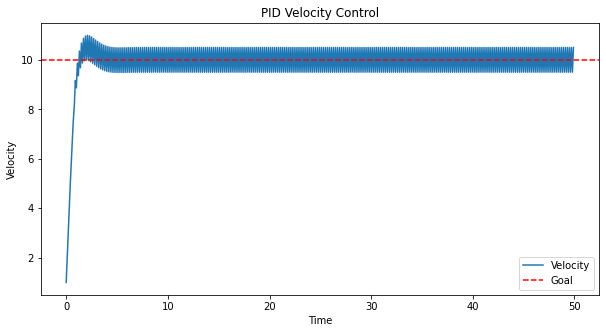

In [38]:
max_time = 50

pid = NewPID(intertia = 5, max_torque=50, overshoot_threshold = 1)
pid.reset()
data2 = pid.auto_tune_gradient_descent(goal, max_iter=1000, max_time = max_time, learning_rate=10, auto_accept=True)
pid.reset()
time = np.arange(0, max_time, dt)
data = []

# Try and run the simulation
for _ in time:
    actual = pid.simulate_motion(goal)
    data.append(actual)

# Create a Graph
plt.figure(figsize=(10, 5))
plt.plot(time, data, label="Velocity")
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("PID Velocity Control")
plt.legend()
plt.show()

# Graph Data 2

# plt.figure(figsize=(10, 5))
# plt.plot(time, data2, label="Velocity")
# plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
# plt.xlabel("Time")
# plt.ylabel("Velocity")
# plt.title("PID Velocity Control")
# plt.legend()
# plt.show()

Stable oscillations detected: Kp=0.41000000000000003, Tu=62.79999999999998, Aplitudes=[0.08381279790999763, 0.02148570512955139, 0.055973058383317564, 0.08830344000174506, 0.031213884060878883, 0.10530433641291559, 0.0242203556782421, 0.06926981958799416, 0.11150545656683697, 0.037234465015078655, 0.06050077274173127, 0.10814937828275539, 0.02577730948555157, 0.07148481020838204, 0.11433621242954928, 0.12369979863856351, 0.03791888111831554, 0.08497360287481648, 0.005381654232522237, 0.05050616096134064, 0.11613442369438509, 0.03054419162753419, 0.07785263059122727, 0.12220117650044315, 0.043803562130518614]
Amplitude ratio: 3.90086326721117
Tuned PID values: Kp=0.0512707024829879, Ki=0.0016328249198403794, Kd=1.0721934386052359


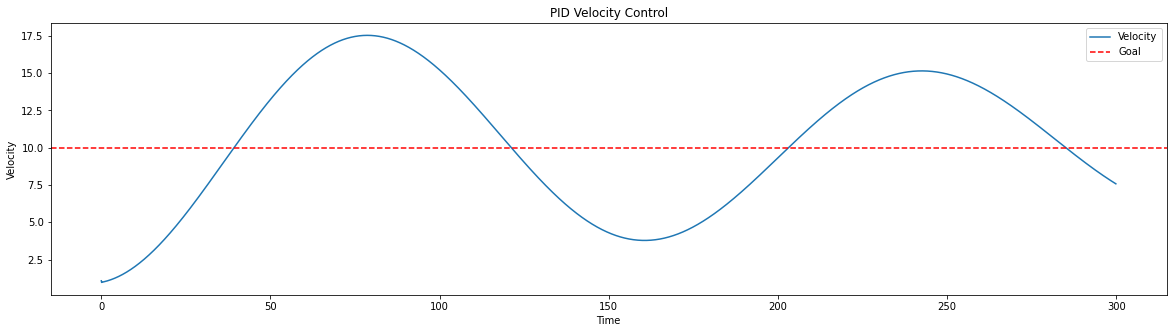

In [33]:
time_frame = 300

pid = NewPID(intertia=10, max_torque=200)
pid.reset()
pid.auto_tune_zieger(goal, max_time = time_frame)
pid.reset()
time = np.arange(0, 300, dt)
data = []

# Try and run the simulation
for _ in time:
    actual = pid.simulate_motion(goal)
    data.append(actual)

# Create a Graph
plt.figure(figsize=(20, 5))
plt.plot(time, data, label="Velocity")
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("PID Velocity Control")
plt.legend()
plt.show()

Tuned PID values: Kp=179.31137931034482, Ki=0.01, Kd=20.698620689655176, Min Error=1014.9999999999978, Overshoot=0.006161145855349659


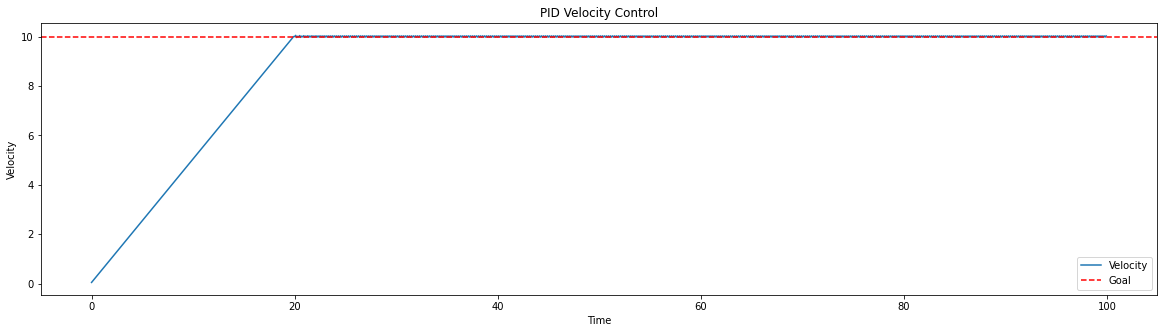

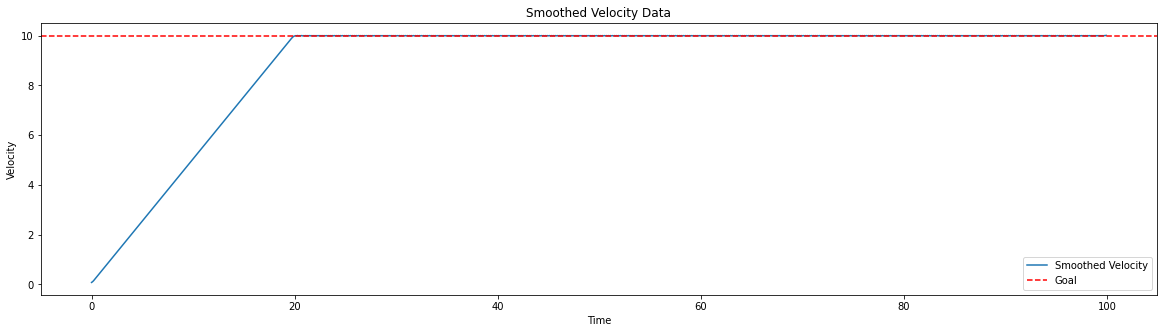

In [34]:
time_frame = 100

pid = NewPID(intertia=10, max_torque=5)
pid.reset()
data2 = pid.auto_tune_range(goal, max_time=time_frame)
pid.reset()
time = np.arange(0, time_frame, dt)
data = []

# Try and run the simulation
for _ in time:
    actual = pid.simulate_motion(goal)
    data.append(actual)

# Create a Graph
plt.figure(figsize=(20, 5))
plt.plot(time, data, label="Velocity")
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("PID Velocity Control")
plt.legend()
plt.show()

# Also show the smoothed data
plt.figure(figsize=(20, 5))
plt.plot(time, data2, label="Smoothed Velocity")
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("Smoothed Velocity Data")
plt.legend()
plt.show()
